In [1]:
import sys
sys.path.append("/home/anonymous/ECAP/nyx/")

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time
import astropy.units as u

# Testing global configuration:

In [3]:
from nyx.core import config_summary, set_healpix_nside, config_context, get_wavelengths, get_healpix_nside, get_grid_dim, set_wavelengths, set_parameter

In [4]:
set_healpix_nside(2**4)
config_summary()

NYX Global Configuration
wavelengths                   : array(shape=(50,), dtype=float32)
                                (Wavelength grid in nm)
healpix_nside                 : 16
                                (HEALPix nside parameter)
use_hemisphere                : True
                                (Whether to use only upper hemisphere)
airmass_formula               : kasten_young_1989
                                (Airmass calculation formula)
grid_dim                      : 2
                                (Image interpolation grid dimension)
use_jit                       : True
                                (Whether to use JAX JIT compilation)
precision                     : float32
                                (Numerical precision for calculations)
spectral_method               : conserve
                                (Spectral interpolation method)
                                (Warn when spectral resolution is degraded)
gradient_checkpointing        : False
 

# Testing spectral interpolation:

In [5]:
from nyx.core import SpectralHandler

In [6]:
from nyx import ASSETS_PATH
ag_array = np.genfromtxt(ASSETS_PATH+'eso_skycalc_airglow_130sfu.dat')
wl_high = jnp.array(ag_array[:,0].flatten())
flux_high = jnp.array(ag_array[:,1].flatten())

In [7]:
results = {}
methods = ['linear', 'conserve']
for method in methods:
    with config_context(spectral_method=method, spectral_resolution_warning=False, wavelengths=jnp.linspace(320,700,30)):
        wl_low = get_wavelengths()
        flux_low = SpectralHandler.resample(wl_high, flux_high, wl_low)
        results[method] = flux_low
        
        # Calculate total flux
        mask = (wl_high>=jnp.min(wl_low))&(wl_high<=jnp.max(wl_low))
        total_in = jnp.trapezoid(flux_high[mask], wl_high[mask])
        total_out = jnp.trapezoid(flux_low, wl_low)
        conservation = total_out / total_in
        
        print(f"\n  {method.upper()} method:")
        print(f"    Flux conservation: {conservation:.1%}")
        print(f"    Peak preservation: {flux_low.max() / flux_high.max():.1%}")



  LINEAR method:
    Flux conservation: 82.7%
    Peak preservation: 0.0%

  CONSERVE method:
    Flux conservation: 99.7%
    Peak preservation: 0.0%


# Testing observation implementation:

In [8]:
import astropy
from astropy.coordinates import SkyCoord, Angle
from nyx.core import Observation

In [9]:
rotation = -0.25*u.deg
location = astropy.coordinates.EarthLocation.from_geodetic(16.5028, -23.27280, 1.8*u.km)
obstime  = astropy.time.Time('2021-06-04T23:14:16', format='isot', scale='utc')
target   = SkyCoord.from_name('sgr A*')
obs = Observation(location, obstime, target, rotation, fov=Angle(3*u.deg))

In [10]:
with config_context(grid_dim=4):
    print(obs.get_eval_coordinates(altaz=True))

<SkyCoord (AltAz: obstime=2021-06-04T23:14:16.000, location=(5622.333422015386, 1665.7099041749266, -2505.2121403078927) km, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    [[(116.31093559, 77.38343026), (125.458609  , 77.70892376),
      (134.85324355, 77.71550364), (144.01976504, 77.40267013)],
     [(113.72509169, 79.31454056), (124.5167718 , 79.70046369),
      (135.72252247, 79.70830835), (146.54548836, 79.33724   )],
     [(110.0255046 , 81.21519256), (123.12978919, 81.68799223),
      (137.00345358, 81.69769638), (150.16485905, 81.24276525)],
     [(104.34274966, 83.06031263), (120.88103808, 83.66773076),
      (139.08280482, 83.68043992), (155.74040685, 83.09515528)]]>


# Testing atmosphere implementation:

In [11]:
from nyx.atmosphere import atmospheres

In [39]:
oz = np.genfromtxt('absorption.txt')
oz_wvl, oz_tau = jnp.array(oz[:,0]), -np.log(jnp.array(oz[:,2]))
atmo = atmospheres.SingleScatteringAtmosphere(
        tau_rayleigh_func=lambda lam, h: 0.00878*(lam/1000)**-4.09 * jnp.exp(-h/8),
        tau_mie_func=lambda lam, h, aod, ang: aod*(lam/500)**(-ang) * jnp.exp(-h/1.54),
        tau_absorption_func=lambda lam, h: jnp.interp(lam, oz_wvl, oz_tau) * jnp.exp(-(h-2.6)/7),
        hg_asymmetry=0.7
        )

In [40]:
%%time
atmo_gen, atmo_par = atmo.get_generator(obs)

CPU times: user 19.6 ms, sys: 570 μs, total: 20.2 ms
Wall time: 19.1 ms


In [41]:
%%time
params = {k:atmo_par[k].initial_value*0.95 for k in atmo_par}
res = atmo_gen(params)

CPU times: user 481 ms, sys: 25.5 ms, total: 507 ms
Wall time: 393 ms


# Testing instrument implementation:

In [42]:
from nyx.instrument import instruments

In [43]:
from nsb2.instrument import HESS
hess1 = HESS.CT1()
grid = np.stack([np.vstack(pix.centers) for pix in hess1.pixels])
values = np.stack([pix.values for pix in hess1.pixels])

HESS1 = instruments.EffectiveApertureInstrument(hess1.bandpass, grid, values)

In [44]:
%%time
inst_gen, inst_par = HESS1.get_generator(obs)

CPU times: user 8.29 ms, sys: 953 μs, total: 9.24 ms
Wall time: 6.87 ms


In [45]:
%%time
params = {k:inst_par[k].initial_value for k in inst_par}
res_inst = inst_gen(params)

CPU times: user 407 μs, sys: 288 μs, total: 695 μs
Wall time: 538 μs


# Testing zodiacal light implementation:

In [46]:
from nyx.emitter import zodiacal
leinert = zodiacal.Leinert1998()

In [47]:
%%time
zod_gen, zod_par, zod_type = leinert.get_generator(obs)

CPU times: user 16.6 ms, sys: 1.49 ms, total: 18.1 ms
Wall time: 17.1 ms


In [48]:
%%time
params = {k:zod_par[k].initial_value for k in zod_par}
res = zod_gen(params)

CPU times: user 478 μs, sys: 338 μs, total: 816 μs
Wall time: 580 μs


# Testing airglow implementation:

In [49]:
from nyx.emitter import airglow
glow = airglow.ESOSkyCalc()

In [50]:
%%time
glow_gen, glow_par, glow_type = glow.get_generator(obs)

CPU times: user 9.85 ms, sys: 982 μs, total: 10.8 ms
Wall time: 8.09 ms


In [51]:
%%time
params = {k:glow_par[k].initial_value for k in glow_par}
res = glow_gen(params)

CPU times: user 2.02 ms, sys: 316 μs, total: 2.34 ms
Wall time: 1.69 ms


In [52]:
res.flux_map.shape

(1504, 50)

# Testing moonlight implementation:

In [53]:
from nyx.emitter import moon
jones = moon.Jones2013()

In [54]:
%%time
moon_gen, moon_par, moon_type = jones.get_generator(obs)

CPU times: user 25.8 ms, sys: 5.27 ms, total: 31.1 ms
Wall time: 25.4 ms


/home/anonymous/ECAP/nyx/nyx/atmosphere/airmass.py:7: RuntimeWarning: invalid value encountered in scalar power
  return 1/(np.cos(Z) + 0.50572*(96.07995-np.rad2deg(Z))**(-1.6364))


In [55]:
%%time
params = {k:moon_par[k].initial_value for k in moon_par}
res = moon_gen(params)

CPU times: user 387 μs, sys: 274 μs, total: 661 μs
Wall time: 351 μs


# Testing stellar catalog implementation:

In [56]:
from nyx.emitter import stars
gaia = stars.GaiaDR3(lim_mag=12)

/usr/local/lib/python3.13/site-packages/astropy/units/quantity.py:1865: RuntimeWarning: All-NaN slice encountered
  result = super().__array_function__(function, types, args, kwargs)


In [57]:
%%time
stars_gen, stars_par, stars_type = gaia.get_generator(obs)

CPU times: user 64.8 ms, sys: 77.4 ms, total: 142 ms
Wall time: 61.2 ms


In [58]:
params = {k:stars_par[k].initial_value for k in stars_par}
res = stars_gen(params)

# Testing model implementation:

In [59]:
from nyx.core.model import Model

In [60]:
pipeline = Model(HESS1, atmo, [glow, leinert, gaia, jones])
pipe_moon = Model(HESS1, atmo, [jones])
scene = pipeline.query(obs)

/home/anonymous/ECAP/nyx/nyx/atmosphere/airmass.py:7: RuntimeWarning: invalid value encountered in scalar power
  return 1/(np.cos(Z) + 0.50572*(96.07995-np.rad2deg(Z))**(-1.6364))


In [61]:
print("\nInitial Parameters:")
scene.print_parameters(format='table')


Initial Parameters:
┌───────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Component  │ Type       │ Parameter    │ Shape │ Initial  │ Current │ Bounds │ Description            │ 
├───────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ atmosphere │ atmosphere │ aod_500      │ (1,)  │ 0.1000   │ -       │ -      │ AOD at 500nm           │ 
│ atmosphere │ atmosphere │ angstrom_exp │ (1,)  │ 1.0000   │ -       │ -      │ Angstrom exponent      │ 
│ atmosphere │ atmosphere │ hg_asymmetry │ (1,)  │ 0.7000   │ -       │ (0, 1) │ HG asymmetry           │ 
│ instrument │ instrument │ shift        │ (2,)  │ -        │ -       │ -      │ Pixel shift in rad     │ 
│ emitter_0  │ diffuse    │ sfu          │ (1,)  │ 100.0000 │ -       │ -      │ Solar flux value [SFU] │ 
└───────────────────────────────────────────────────────────────────────────────────────────────────────┘

Total parameters: 

# Testing scene rendering:

In [62]:
from nyx.core.integrator import render

In [63]:
%%time
initial_params = scene.get_initial_parameters()
scene_instance = scene.realize(initial_params)
img = render(scene_instance)

CPU times: user 738 ms, sys: 37.3 ms, total: 775 ms
Wall time: 358 ms


# Visualize data

In [64]:
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
cam = CameraGeometry.from_name('HESS-I')
def ctapipe_disp(cam, rates, ax, label='a.u.', **kwargs):
    display = CameraDisplay(cam, ax=ax, **kwargs)
    display.image = rates
    display.add_colorbar(label=label)
    return display

/usr/local/lib/python3.13/site-packages/ctapipe/instrument/camera/geometry.py:616: FromNameWarning: .from_name uses pre-defined data that is likely different from the data being analyzed. Access instrument information via the SubarrayDescription instead.
  warn_from_name()


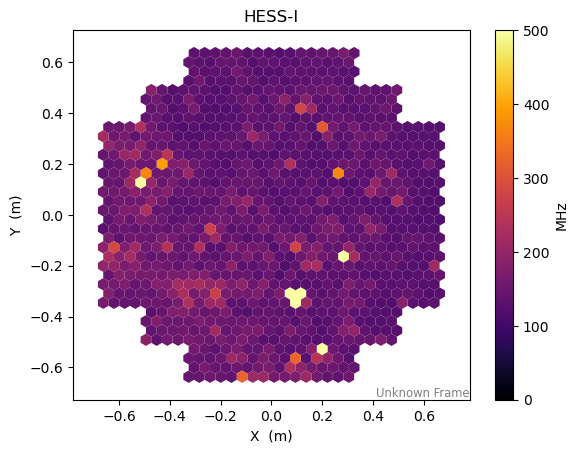

In [65]:
fig, ax = plt.subplots()
disp = ctapipe_disp(cam, img/1e6, ax, label='MHz')
disp.set_limits_minmax(0, 500)

# Compare to data

In [66]:
from astropy.coordinates import AltAz
def frame_from_data(row, offsets=(0,0)):
    location = EarthLocation.from_geodetic(16.50097, -23.271514, 1800.)

    file = '/home/anonymous/ECAP/nyx/examples/nsb_CT1_{}_0.npy'.format(row.Run)
    df = pd.DataFrame.from_records(np.load(file))
    pivoted = df.pivot(columns='Pixel', index='Time', values='NSB').reindex(columns=np.arange(0, 960))
    pivoted.index = pivoted.index.astype(str).str.replace("UTC: ", "")
    pivoted = pivoted.reset_index()

    observations = []
    for i, data in pivoted.iterrows():
        obstime  = astropy.time.Time(data['Time'].replace(" ", 'T'), format='isot', scale='utc')
        altaz  = AltAz(obstime=obstime, location=location)
        
        ra, dec = row['Target_RA'] + row['Offset_x'] + offsets[0], row['Target_Dec'] + row['Offset_y']+offsets[1]
        target = SkyCoord(ra=ra, dec=dec, frame="icrs", unit="deg").transform_to(altaz)
        
        observations.append(Observation(location, obstime, target, -0.25*u.deg, fov=Angle(3*u.deg)))

    return observations, pivoted


def hap2cta(series, telId):
    if telId == 5:
        None
    else:
        reassign = pd.read_csv('/home/anonymous/ECAP/nyx/examples/ct1_pixel_assignment.txt', sep=' ', names=['old', 'new'], dtype=np.int32)
    
    re_dict = reassign.to_dict()['new']
    return series.rename(re_dict).reindex(np.arange(0,960)).fillna(np.nan).values


all_results = np.load('/home/anonymous/ECAP/nyx/ff_corr.npy')
def correct(run, img):
    if run < 163380:
        corr = all_results[0]
    elif run > 166200:
        corr = all_results[2]
    else:
        corr = all_results[1]
    return (img-corr[:,1])/corr[:,0]

In [67]:
import pandas as pd
df = pd.read_csv('/home/anonymous/ECAP/nyx/RunInformation.csv')
m_df = df[df['RunType'] == 'MoonlightObservationRun']

/tmp/ipykernel_603457/3543425293.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return series.rename(re_dict).reindex(np.arange(0,960)).fillna(np.nan).values


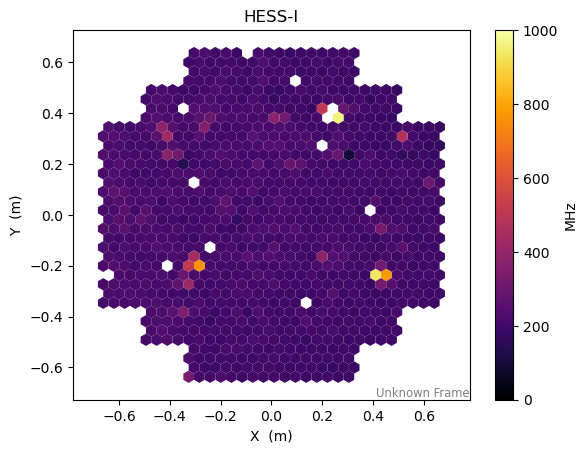

In [68]:
obs_id = 15

row = m_df.loc[14105]
observations, pivoted = frame_from_data(row)

run_img = correct(row.Run, hap2cta(pivoted.iloc[obs_id][1:],1))

fig, ax = plt.subplots()
disp = ctapipe_disp(cam, run_img, ax, label='MHz')
disp.set_limits_minmax(0, 1000)

In [69]:
scene = pipeline.query(observations[obs_id])
initial_params = scene.get_initial_parameters()

In [70]:
import jax
import jax.numpy as jnp
from jax import checkpoint

valid_mask = ~jnp.isnan(run_img)
n_valid = jnp.sum(valid_mask)

@jax.jit
def loss_fn(shift):
    flat_params = initial_params.copy()
    start, end = scene.parameters['instrument']['parameters']['shift']['flat_indices']
    flat_params = flat_params.at[start:end].set(shift/3600/180*jnp.pi)
    
    scene_instance = scene.realize(flat_params)
    pred = render(scene_instance) / 1e6
    
    run_img_safe = jnp.where(valid_mask, run_img, 0.0)
    pred_safe = jnp.where(valid_mask, pred, 0.0)
    likelihood = (pred_safe - run_img_safe)**2 / (2*0.2*pred_safe + 1e-11)
    return jnp.sum(likelihood * valid_mask)

# Get gradient function
grad_fn = jax.grad(loss_fn)

initial_shift = jnp.zeros(2)
base_params = scene.unpack_parameters(initial_params)

loss_and_grad_fn = jax.value_and_grad(loss_fn)
loss, grads = loss_and_grad_fn(initial_shift)

# Using optax

In [71]:
import optax
# Start optimizer
learning_rate = 1e1
optimizer = optax.adam(learning_rate)
shift = jnp.zeros(2)  # initial guess
opt_state = optimizer.init(shift)

# Define step
@jax.jit
def loss_step(shift, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(shift)
    updates, opt_state = optimizer.update(grads, opt_state)
    shift = optax.apply_updates(shift, updates)
    return shift, opt_state, loss

# Optimization
for step in range(200):
    shift, opt_state, loss = loss_step(shift, opt_state)
    if step % 50 == 0:
        print(f"Step {step}, loss={loss:.6f}")

print("Optimized shift:", shift)

Step 0, loss=40692.750000
Step 50, loss=6549.916992
Step 100, loss=6521.323242
Step 150, loss=6507.873047
Optimized shift: [ 266.82584 -168.41896]


In [72]:
def scan_2d(shift_best, delta=1.0, n_points=30):
    grid = jnp.linspace(-delta, delta, n_points)
    losses = []

    for dx in grid:
        row = []
        for dy in grid:
            s = shift_best.at[0].add(dx).at[1].add(dy)
            loss = float(loss_fn(s))  # convert to host scalar, keeps memory low
            row.append(loss)
        losses.append(row)
    losses = jnp.array(losses)
    return grid, grid, losses

In [73]:
%%time
gridx, gridy, Z = scan_2d(shift, delta=60, n_points=40)

CPU times: user 1min 36s, sys: 345 ms, total: 1min 37s
Wall time: 13 s


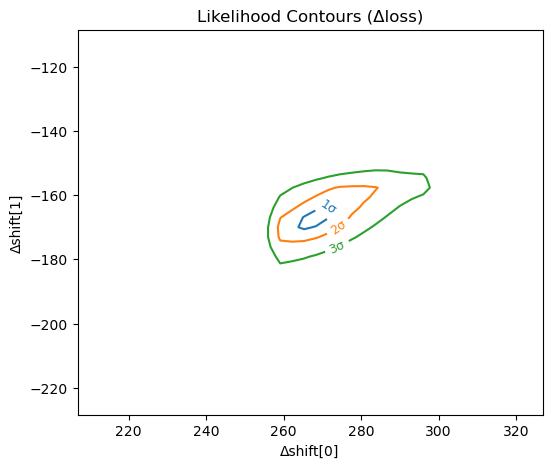

In [74]:
import jax.numpy as jnp

loss_min = jnp.min(Z)
deltaZ = np.sqrt(2*(Z-loss_min))

import matplotlib.pyplot as plt

X, Y = jnp.meshgrid(gridx, gridy)
X = X+shift[0]
Y = Y+shift[1]

fig, ax = plt.subplots(figsize=(6, 5))
CS = ax.contour(
    X, Y, deltaZ,
    levels=[2.3, 6.18, 11.83],   # 1σ, 2σ, 3σ for 2D case
    colors=['C0', 'C1', 'C2'],
)
ax.clabel(CS, fmt={2.3:'1σ', 6.18:'2σ', 11.83:'3σ'}, fontsize=9)
ax.set_xlabel("Δshift[0]")
ax.set_ylabel("Δshift[1]")
ax.set_title("Likelihood Contours (Δloss)")
plt.show()

# Result side by side:

In [139]:
base_params['instrument']['shift'] = shift/3600/180*jnp.pi
scene_instance = scene.realize(base_params)
scene_initial = scene.realize(initial_params)
img = render(scene_instance)
img_old = render(scene_initial)

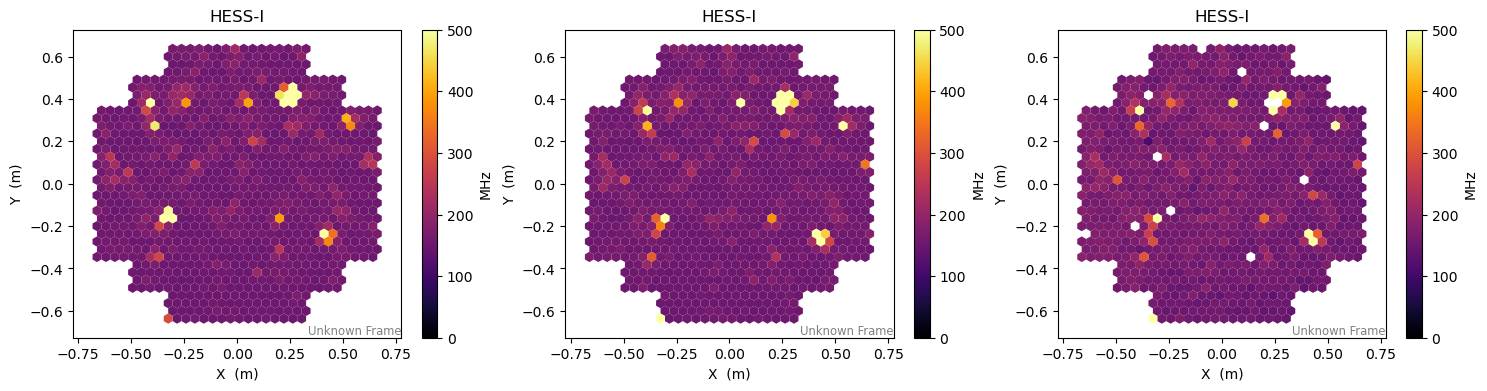

In [140]:
fig, ax = plt.subplots(ncols=3, figsize=(18,4))
disp1 = ctapipe_disp(cam, run_img, ax[2], label='MHz')
disp2 = ctapipe_disp(cam, img/1e6, ax[1], label='MHz')
disp3 = ctapipe_disp(cam, img_old/1e6, ax[0], label='MHz')
disp1.set_limits_minmax(0, 500)
disp2.set_limits_minmax(0, 500)
disp3.set_limits_minmax(0, 500)

# Multifit:

In [194]:
obs_id = [0,10,15,20,25,30]

row = m_df.loc[14105]
observations, pivoted = frame_from_data(row)

run_imgs = jnp.array([correct(row.Run, hap2cta(pivoted.iloc[ids][1:],1)) for ids in obs_id])

/tmp/ipykernel_566919/3543425293.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return series.rename(re_dict).reindex(np.arange(0,960)).fillna(np.nan).values
/tmp/ipykernel_566919/3543425293.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return series.rename(re_dict).reindex(np.arange(0,960)).fillna(np.nan).values
/tmp/ipykernel_566919/3543425293.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the fut

In [195]:
scenes = [pipeline.query(observations[ids]) for ids in obs_id]
initial_params = scenes[0].get_initial_parameters()

In [196]:
import jax
import jax.numpy as jnp
from jax import checkpoint

# Define loss function that takes shift as input
valid_mask = ~jnp.isnan(run_imgs)
n_valid = jnp.sum(valid_mask, axis=1)

@jax.jit
def loss_fn(shift):
    flat_params = initial_params.copy()
    start, end = scenes[0].parameters['instrument']['parameters']['shift']['flat_indices']
    flat_params = flat_params.at[start:end].set(shift/3600/180*jnp.pi)

    lsum = 0
    for i in range(len(obs_id)):
        scene_instance = scenes[i].realize(flat_params)
        pred = render(scene_instance) / 1e6
        
        run_img_safe = jnp.where(valid_mask[i], run_imgs[i], 0.0)
        pred_safe = jnp.where(valid_mask[i], pred, 0.0)
        likelihood = (pred_safe - run_img_safe)**2 / (2*0.2*pred_safe + 1e-11)
        
        lsum += jnp.sum(likelihood * valid_mask[i])

    return lsum

# Get gradient function
grad_fn = jax.grad(loss_fn)

# Initial shift value (JAX infers shape from this)
initial_shift = jnp.zeros(2)  # Shape (2,) for x,y shift
base_params = scene.unpack_parameters(initial_params)

# Or use value_and_grad for both at once
loss_and_grad_fn = jax.value_and_grad(loss_fn)
loss, grads = loss_and_grad_fn(initial_shift)

In [197]:
# --- Initialize optimizer ---
learning_rate = 1e1
optimizer = optax.adam(learning_rate)
shift = jnp.zeros(2)  # initial guess
opt_state = optimizer.init(shift)

# --- Training step ---
@jax.jit
def train_step(shift, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(shift)
    updates, opt_state = optimizer.update(grads, opt_state)
    shift = optax.apply_updates(shift, updates)
    return shift, opt_state, loss

# --- Optimization loop ---
for step in range(200):
    shift, opt_state, loss = train_step(shift, opt_state)
    if step % 50 == 0:
        print(f"Step {step}, loss={loss:.6f}")

print("Optimized shift:", shift)

Step 0, loss=240167.890625
Step 50, loss=79823.234375
Step 100, loss=79046.773438
Step 150, loss=79040.085938
Optimized shift: [ 268.1057  -156.58891]


In [198]:
%%time
gridx, gridy, Z = scan_2d(shift, delta=20, n_points=30)

CPU times: user 5min 53s, sys: 46.6 s, total: 6min 40s
Wall time: 49.2 s


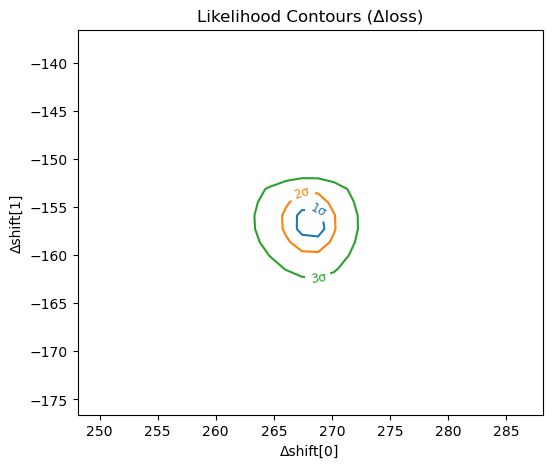

In [199]:
import jax.numpy as jnp

loss_min = jnp.min(Z)
deltaZ = np.sqrt(2*(Z-loss_min))

import matplotlib.pyplot as plt

X, Y = jnp.meshgrid(gridx, gridy)
X = X+shift[0]
Y = Y+shift[1]

fig, ax = plt.subplots(figsize=(6, 5))
CS = ax.contour(
    X, Y, deltaZ,
    levels=[2.3, 6.18, 11.83],   # 1σ, 2σ, 3σ for 2D case
    colors=['C0', 'C1', 'C2'],
)
ax.clabel(CS, fmt={2.3:'1σ', 6.18:'2σ', 11.83:'3σ'}, fontsize=9)
ax.set_xlabel("Δshift[0]")
ax.set_ylabel("Δshift[1]")
ax.set_title("Likelihood Contours (Δloss)")
plt.show()